In [319]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [320]:
TRAINING_SIZE = 10000
TRAIN_PERCENT = 0.8
VAL_PERCENT = 0.1
TEST_PERCENT = 1.0 - TRAIN_PERCENT - VAL_PERCENT
BATCH_SIZE = 64
MAX_LEN = 128
EMBED_DIM = 128
LEARNING_RATE = 1e-3
EPOCHS = 50
PATIENCE = 3
RUN_NAME = "run1"
MODEL_OUTPUT = "./pytorch_output/" + RUN_NAME + ".pt"

In [321]:
from nltk.corpus import twitter_samples

In [322]:
assert TRAINING_SIZE <= 10000
postive_tweets = twitter_samples.strings("positive_tweets.json")[
    : int(TRAINING_SIZE / 2)
]
negative_tweets = twitter_samples.strings("negative_tweets.json")[
    : int(TRAINING_SIZE / 2)
]

print("Number of positive tweets: ", len(postive_tweets))
print("Number of negative tweets: ", len(negative_tweets))
print("Total number of tweets: ", len(postive_tweets) + len(negative_tweets))

Number of positive tweets:  5000
Number of negative tweets:  5000
Total number of tweets:  10000


In [323]:
tweets = postive_tweets + negative_tweets
labels = [1] * len(postive_tweets) + [0] * len(negative_tweets)

In [324]:
from htwgnlp.preprocessing import TweetProcessor
from pytorch_nlp.dataset import SentimentDataset

tweet_processor = TweetProcessor()

dataset = SentimentDataset(
    tweets=tweets,
    labels=labels,
    processor=tweet_processor.process_tweet,
    max_length=MAX_LEN,
)

dataset[0]

(tensor([2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(1))

In [325]:
import torch
from torch.utils.data import DataLoader

assert TRAIN_PERCENT + VAL_PERCENT + TEST_PERCENT == 1

train_size = int(TRAIN_PERCENT * len(dataset))
val_size = int(VAL_PERCENT * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

print(
    f"Train Size: {len(train_dataset)}, Validation Size: {len(val_dataset)}, Test Size: {len(test_dataset)}"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train Size: 8000, Validation Size: 1000, Test Size: 1000


In [326]:
from pytorch_nlp.model import SentimentModel
from torchinfo import summary

model = SentimentModel(vocab_size=len(dataset.vocab), embedding_dim=EMBED_DIM)

summary(model, input_size=(BATCH_SIZE, MAX_LEN), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
SentimentModel                           [64, 1]                   --
├─Embedding: 1-1                         [64, 128, 128]            1,344,896
├─Linear: 1-2                            [64, 1]                   129
├─Sigmoid: 1-3                           [64, 1]                   --
Total params: 1,345,025
Trainable params: 1,345,025
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 86.08
Input size (MB): 0.07
Forward/backward pass size (MB): 8.39
Params size (MB): 5.38
Estimated Total Size (MB): 13.83

In [327]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (embedding): Embedding(10507, 128, padding_idx=0)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [328]:
import torch.nn as nn
import torch.optim as optim
from pytorch_nlp.train import train_model

criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=EPOCHS,
    early_stopping=True,
    patience=5,
    model_output=MODEL_OUTPUT,
)

Epoch [1/50]
  Train Loss: 0.6777
  Val Loss:   0.6590
  Val Acc:    0.9320
  Validation loss improved. Model saved!
Epoch [2/50]
  Train Loss: 0.6279
  Val Loss:   0.5963
  Val Acc:    0.9770
  Validation loss improved. Model saved!
Epoch [3/50]
  Train Loss: 0.5470
  Val Loss:   0.5076
  Val Acc:    0.9860
  Validation loss improved. Model saved!
Epoch [4/50]
  Train Loss: 0.4477
  Val Loss:   0.4119
  Val Acc:    0.9950
  Validation loss improved. Model saved!
Epoch [5/50]
  Train Loss: 0.3514
  Val Loss:   0.3263
  Val Acc:    0.9970
  Validation loss improved. Model saved!
Epoch [6/50]
  Train Loss: 0.2708
  Val Loss:   0.2574
  Val Acc:    0.9980
  Validation loss improved. Model saved!
Epoch [7/50]
  Train Loss: 0.2085
  Val Loss:   0.2043
  Val Acc:    0.9980
  Validation loss improved. Model saved!
Epoch [8/50]
  Train Loss: 0.1620
  Val Loss:   0.1642
  Val Acc:    0.9980
  Validation loss improved. Model saved!
Epoch [9/50]
  Train Loss: 0.1275
  Val Loss:   0.1338
  Val Acc

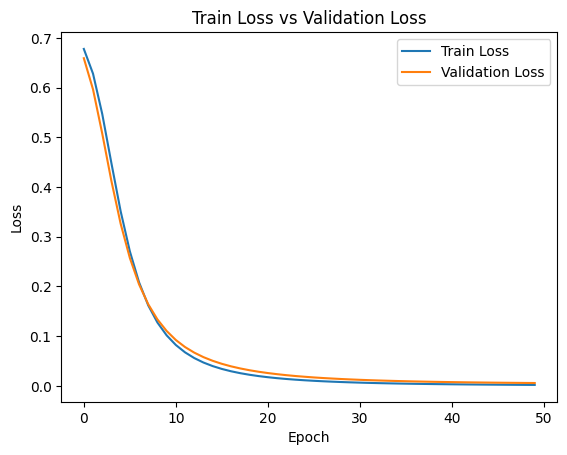

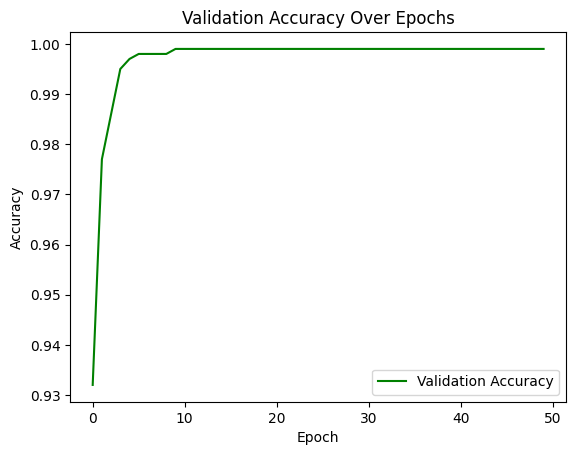

In [329]:
# Visualize the training history (example with matplotlib)
import matplotlib.pyplot as plt

# Plot training loss and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss vs Validation Loss")
plt.show()

# Plot validation accuracy
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Over Epochs")
plt.show()

In [338]:
from pytorch_nlp.evaluate import evaluate_model

accuracy, avg_loss = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
)

Test Accuracy: 0.9990
Test Loss: 0.0083
Correctly classified samples: 999
Wrongly classified samples: 1
